In [14]:
import pandas as pd
from pathlib import Path

BASE_DIR = Path().resolve().parent

# Load CSV
bus_stops = pd.read_csv(BASE_DIR / "data" / "raw" / "ets_bus_stops.csv")
libraries = pd.read_csv( BASE_DIR / "data" / "raw" / "edmonton_libraries.csv")
# Keep relevant columns (e.g., latitude, longitude, name)
bus_stops = bus_stops[["stop_id", "stop_name", "latitude", "longitude"]]
libraries = libraries[["name", "latitude", "longitude"]]



In [15]:
from geopy.distance import geodesic

def nearest_library_distance(bus_stop, libraries):
    bus_coords = (bus_stop["latitude"], bus_stop["longitude"])
    distances = libraries.apply(
        lambda lib: geodesic(bus_coords, (lib["latitude"], lib["longitude"])).km,
        axis=1
    )
    return distances.min()

bus_stops["nearest_library_km"] = bus_stops.apply(
    lambda row: nearest_library_distance(row, libraries), axis=1
)


In [16]:
import folium

edmonton_map = folium.Map(location=[53.5461, -113.4938], zoom_start=12)
for _, row in bus_stops.iterrows():
    color = "blue" if row["nearest_library_km"] > 1 else "green"
    folium.CircleMarker(
        [row["latitude"], row["longitude"]],
        radius=3,
        color=color,
        fill=True
    ).add_to(edmonton_map)
edmonton_map.save( BASE_DIR / "visualizations"/"accessibility_map.html")

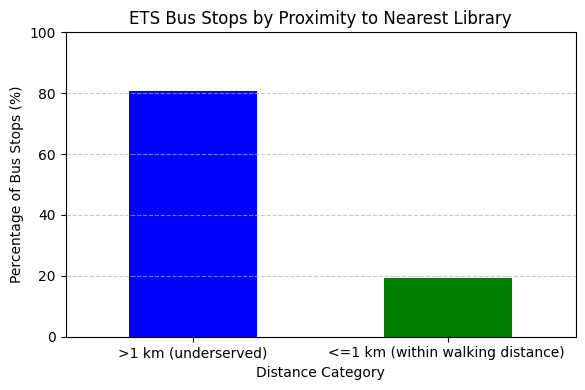

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Categorize bus stops
bus_stops["access_category"] = bus_stops["nearest_library_km"].apply(
    lambda x: "<=1 km (within walking distance) " if x <= 1 else ">1 km (underserved)"
)

# Count categories
category_counts = bus_stops["access_category"].value_counts(normalize=True) * 100

# Plot
plt.figure(figsize=(6, 4))
category_counts.plot(kind='bar', color=['blue', 'green'])
plt.title("ETS Bus Stops by Proximity to Nearest Library")
plt.ylabel("Percentage of Bus Stops (%)")
plt.xlabel("Distance Category")
plt.xticks(rotation=0)
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(BASE_DIR /"visualizations/bus_stop_access_bar_chart.png")
plt.show()

In [18]:
#bus_stops.to_csv("ets_bus_stops_with_library_distance.csv", index=False)
# Save enriched dataset
processed_path = BASE_DIR / "data" / "processed" / "ets_bus_stops_with_library_distance.csv"
bus_stops.to_csv(processed_path, index=False)